In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
import matplotlib.pyplot as plt
import numpy as np

2025-07-11 08:34:45.640840: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 08:34:45.840420: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 08:34:49.218125: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 08:34:51.071777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752233692.175182    1914 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752233692.56

In [2]:
image_size = (28, 28)
batch_size = 32

# Carrega os datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    validation_split=0.2,
    subset="training",
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Obtém os nomes das classes (IMPORTANTE: antes de qualquer transformação)
class_names = train_ds.class_names
print("Classes:", class_names)

# Pipeline de pré-processamento
AUTOTUNE = tf.data.AUTOTUNE

# Augmentation (só para treino)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomZoom(0.1),
])

# Aplica transformações
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                      num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y), 
                       num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (x / 255.0, y), 
                  num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Found 1283 files belonging to 36 classes.
Using 1027 files for training.


2025-07-11 08:35:27.780900: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 1283 files belonging to 36 classes.
Using 256 files for validation.
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [3]:


# Aplica augmentation só no treino
#train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [4]:
weight_decay = 1e-4

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(8, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(16, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)),
    layers.Dropout(0.3),
    
    layers.Dense(len(class_names), activation='softmax')  # Usa a variável salva
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        25,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,252 (114.27 KB)

 Trainable params: 29,252 (114.27 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [6]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0430 - loss: 3.5609 - val_accuracy: 0.1250 - val_loss: 3.3644
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1194 - loss: 3.3340 - val_accuracy: 0.2656 - val_loss: 3.1585
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1310 - loss: 3.2113 - val_accuracy: 0.2852 - val_loss: 2.8253
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2060 - loss: 2.9359 - val_accuracy: 0.4414 - val_loss: 2.3302
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2810 - loss: 2.5209 - val_accuracy: 0.5234 - val_loss: 1.9804
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3588 - loss: 2.2393 - val_accuracy: 0.6328 - val_loss: 1.6660
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4357 - loss: 1.9619 - val_accuracy: 0.7070 - val_loss: 1.4206
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4516 - loss: 1.8648 - val_accuracy: 0.7422 - val_loss

In [7]:
def representative_data_gen():
    for images, _ in train_ds.unbatch().batch(1).take(300):
        yield [tf.cast(images, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
with open("char_model_quant.tflite", "wb") as f:
    f.write(tflite_model)

print("Modelo quantizado salvo como 'char_model_quant.tflite'")

INFO:tensorflow:Assets written to: /tmp/tmp_3y_8cn6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_3y_8cn6/assets


Saved artifact at '/tmp/tmp_3y_8cn6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  125424407408144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407408720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407409296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407409872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407407184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407410832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407411408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125424407411984: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/lcs/.cache/pypoetry/virtualenvs/license-plate-segmentation-hdZWEfc--py3.11/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1752233748.719848    1914 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752233748.719922    1914 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-11 08:35:48.720299: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_3y_8cn6
2025-07-11 08:35:48.720966: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-11 08:35:48.720974: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp_3y_8cn6
I0000 00:00:1752233748.725456    1914 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-07-11 08:35:48.726154: I tensorflow/cc/saved_model/loader

Modelo quantizado salvo como 'char_model_quant.tflite'


2025-07-11 08:35:50.035211: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [8]:
print(history.history.keys())  # Mostra as métricas disponíveis

print("Acurácias de treinamento:", history.history['accuracy'])
print("Acurácias de validação:", history.history['val_accuracy'])
print("Perda de treinamento:", history.history['loss'])
print("Perda de validação:", history.history['val_loss'])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Acurácias de treinamento: [0.04868549108505249, 0.12852969765663147, 0.15579357743263245, 0.22687439620494843, 0.2979552149772644, 0.36124634742736816, 0.4177215099334717, 0.4693281352519989, 0.502434253692627, 0.5121713876724243, 0.5433300733566284, 0.5462512373924255, 0.5900681614875793, 0.6192794442176819, 0.6436222195625305, 0.6358325481414795, 0.657254159450531, 0.6543329954147339, 0.6484907269477844, 0.6777020692825317, 0.7010710835456848, 0.7127556204795837, 0.6874391436576843, 0.7244400978088379, 0.7487828731536865, 0.7341772317886353, 0.7254137992858887, 0.7400195002555847, 0.7370983362197876, 0.7439143061637878, 0.7409932017326355, 0.7604674100875854, 0.7750730514526367, 0.7594936490058899, 0.7731255888938904, 0.7731255888938904, 0.7838364243507385, 0.7828627228736877, 0.7877312302589417, 0.7838364243507385, 0.7925997972488403, 0.8013631701469421, 0.8042843341827393, 0.7906523942947388, 0.80525803565979, 0.8227847814

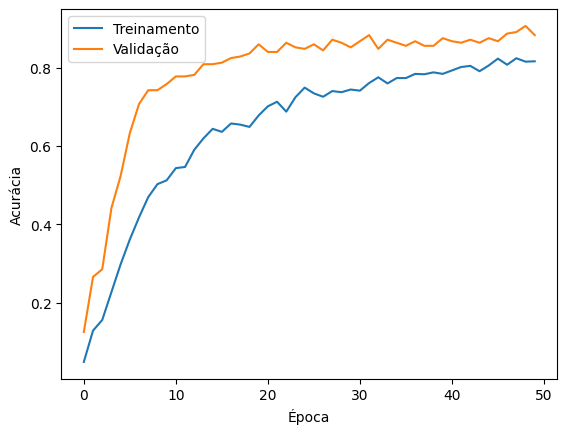

In [9]:
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.show()


In [14]:
for images, labels in val_ds.take(1):
    print("Número de imagens no batch:", len(images))

Número de imagens no batch: 32


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


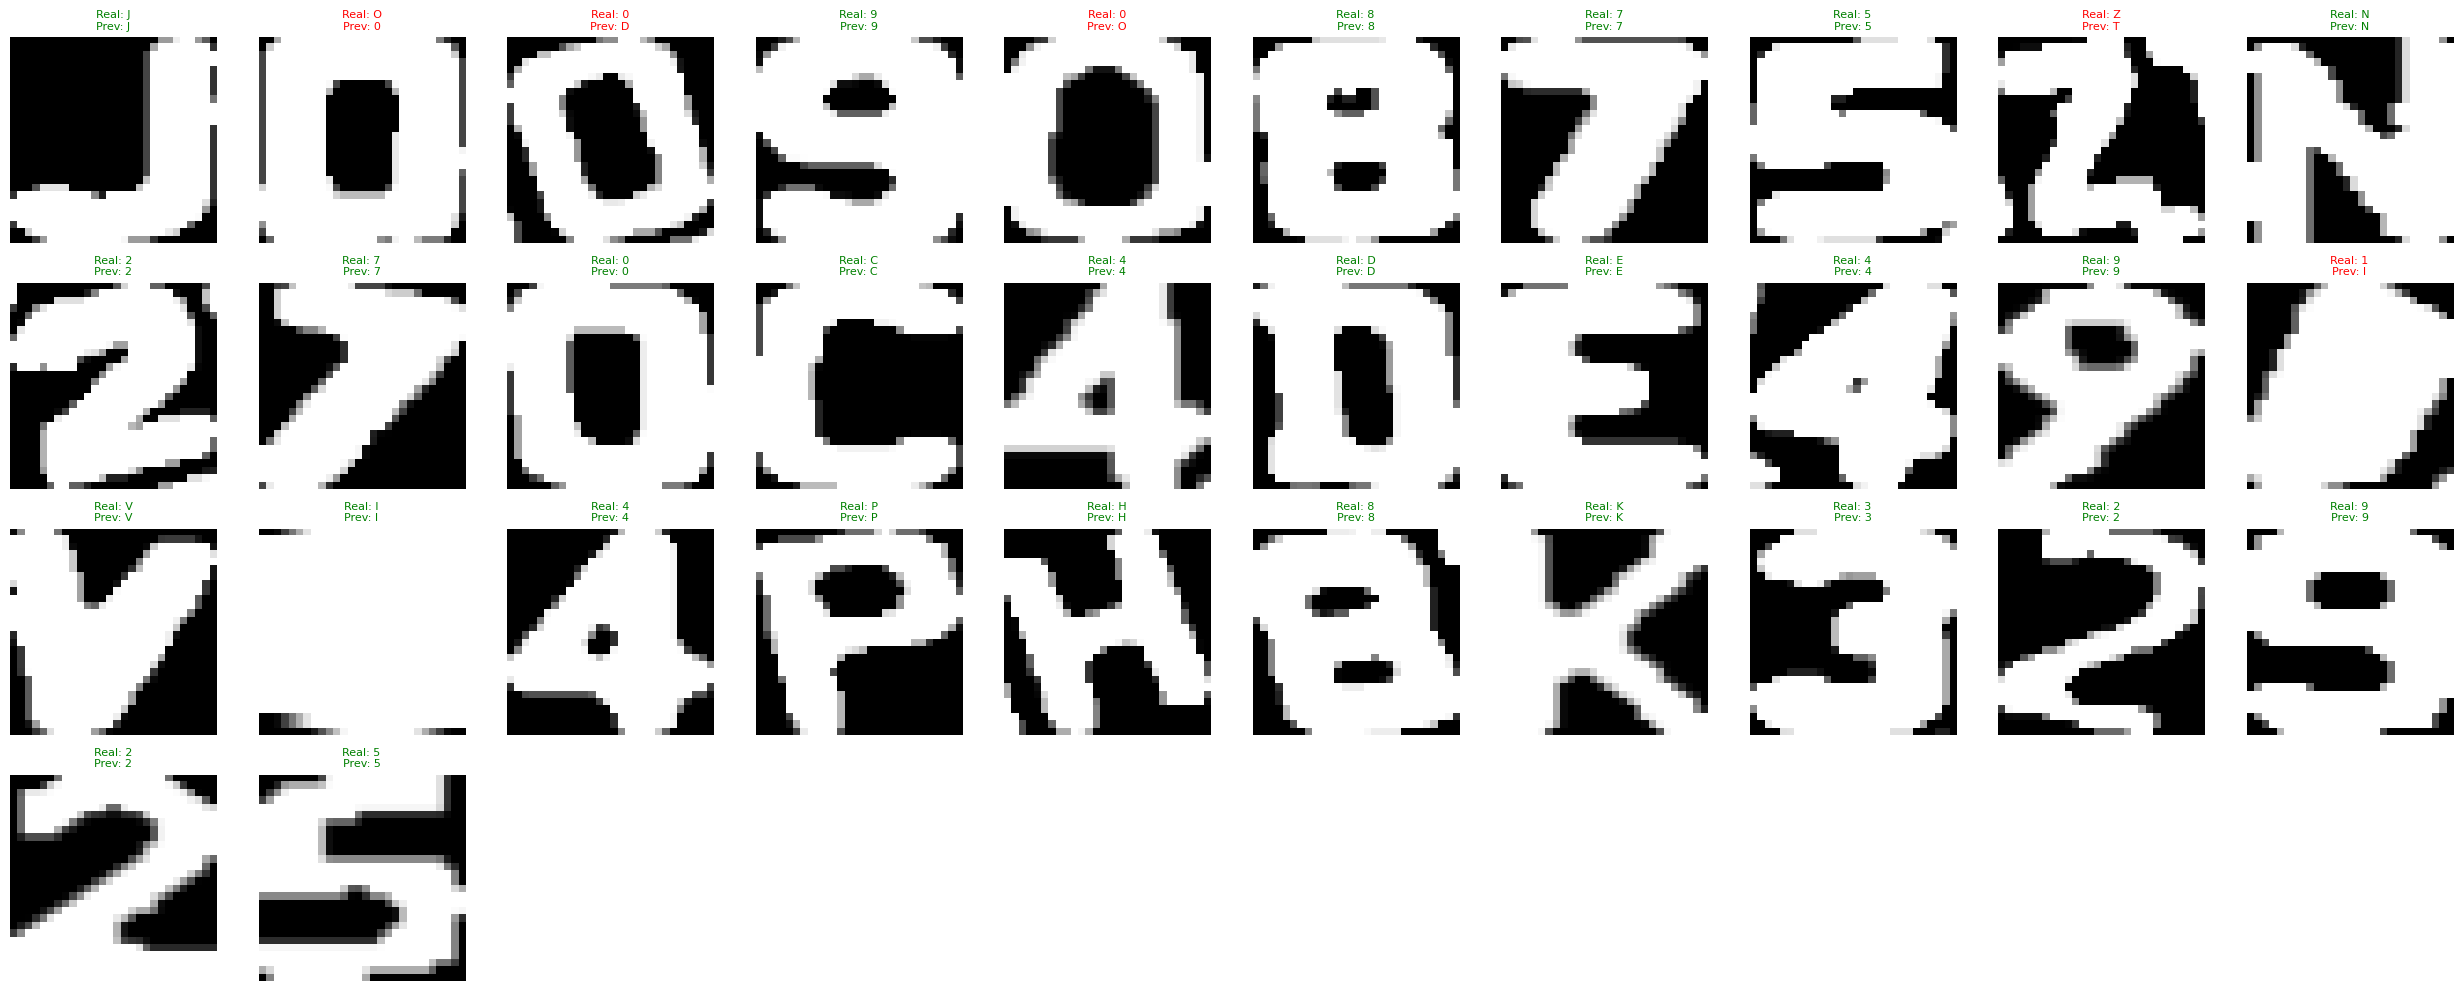

In [16]:
# Obter um batch de imagens da validação
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    num_images = len(images)  # Número real de imagens no batch
    
    # Ajuste o número de linhas/colunas conforme necessário
    n_rows = int(np.ceil(num_images / 10))  # 10 colunas, linhas variáveis
    plt.figure(figsize=(25, n_rows * 2.5))  # Ajuste dinâmico do tamanho
    
    for i in range(num_images):  # Mostra todas as imagens do batch
        ax = plt.subplot(n_rows, 10, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"Real: {true_label}\nPrev: {pred_label}", color=color, fontsize=8)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()